<h1><center><strong><font color="black"> Optimal Transport : Tutorial for the Supervised Word Mover's Distance using the OTT-JAX toolbox </font></strong></center></h1>
<h3><center><font color="black"><strong>Violaine Courrier & Gaspard Michel</strong></font></center></h3>

<center>
2022 
</center>

This tutorial shows how to implement [Supervised Word Mover’s Distance](https://proceedings.neurips.cc/paper/2016/file/10c66082c124f8afe3df4886f5e516e0-Paper.pdf) using ott-jax, sinkhorn divergence and jax gradient functionalities. The first part of this tutorial will be focus on building (normalized) document word histograms and embeddings. To this end, we adapt [ott-jax's tutorial on sinkhorn divergence](https://ott-jax.readthedocs.io/en/latest/notebooks/One_Sinkhorn.html).

In [1]:
import jax
import jax.numpy as jnp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm, trange

In [2]:
!pip install ott-jax
import ott
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.core.sinkhorn import sinkhorn
from ott.geometry.pointcloud import PointCloud
from ott.geometry.geometry import Geometry

## From Texts to Word Histograms


We use the [keras NLP tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/) to preprocess raw text (here a subset of texts from the [BBC](http://mlg.ucd.ie/datasets/bbc.html) database) and turn them into word embeddings histograms.

In [35]:
!wget https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

--2022-05-05 14:42:21--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  --.-KB/s    in 0.03s   

2022-05-05 14:42:22 (162 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]



In [3]:
data = pd.read_csv('bbc-text.csv')
mapper = { i: j for i,j in zip(data['category'].unique(), range(len(data['category'].unique())))}
data['label'] = data['category'].map(lambda x: mapper[x])
print(f'There is {data.shape[0]} texts in the dataset')

samples = []
labels = []
for j in data['label'].unique() : 
    samples.extend(data[data['label']==j].iloc[:80]['text'].tolist())
    labels.extend([j]*80)
print(f'Keeping {len(labels)} texts')

There is 2225 texts in the dataset
Keeping 400 texts


Load $80 \times 5 = 400$ texts, removing headers.

Most of the texts have a length that concentrates around $2000$ words as shown below, very few exceed $10,000$ words.

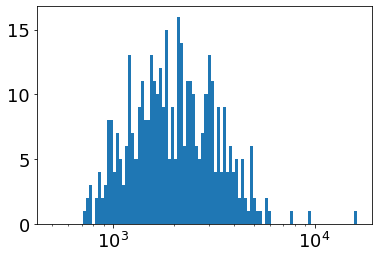

Keeping 400 texts


In [4]:
plt.rcParams.update({'font.size': 18})
text_lengths = [len(sample) for sample in samples]
hist, bins = np.histogram(text_lengths, bins=100)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(text_lengths, bins=logbins)
plt.xscale('log')
plt.show()
#idx_samples_to_drop = [idx for idx, sample in enumerate(samples) if len(sample) < 3000]
#samples = [sample for sample in samples if len(sample) < 2000]
#samples = [j for i, j in enumerate(samples) if i not in idx_samples_to_drop]
#labels = [j for i, j in enumerate(labels) if i not in idx_samples_to_drop]
print(f'Keeping {len(samples)} texts')

This is where we use `tf.keras` code to parse these texts, create a vocabulary index, and map texts onto histograms on that vocabulary.

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=10000)
text_ds = tf.data.Dataset.from_tensor_slices(samples).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


Download pre-trained Word embeddings, here selected to have dimension 50.

In [7]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-05-05 11:45:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-05 11:45:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-05 11:45:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

We extract the embeddings from the `Glove` vectors that correspond to our vocabulary.

In [6]:
embedding_dim = 50
embeddings_index = {}
with open("glove.6B." + str(embedding_dim) +"d.txt") as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
print("Vocabulary size: %s." % len(voc))

num_tokens = len(voc) + 2
hits = 0
misses = 0
max_norm = 0
missed = []
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
embedding_exists = np.zeros((num_tokens,), dtype=bool)
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    max_norm = max(np.sum(embedding_vector ** 2), max_norm)
    hits += 1
    embedding_exists[i] = True
  else:
    misses += 1
    missed.append(word)
print("Converted %d words (%d misses)" % (hits, misses))

# Normalize Vectors to have maximal norm 1.
embedding_matrix /= np.sqrt(max_norm)

Found 400000 word vectors.
Vocabulary size: 14749.
Converted 13478 words (1271 misses)


We can now recover $N$ histograms of size $13478$ (the total number of words in the vocabulary) that have embeddings. These histograms are relatively sparse.

In [7]:
def texts_to_embedding_measures(text):
  hist = vectorizer(text)
  A = np.zeros((len(text), embedding_matrix.shape[0]))
  for i in range(hist.shape[0]):
    A[i, hist[i]] = 1.0
  A = tf.boolean_mask(A, embedding_exists, axis=1)
  return A / tf.reduce_sum(A, axis=1)[:, None]

In [8]:
HIST = texts_to_embedding_measures(samples) # Histograms
HIST = jnp.array(HIST) 
X = jnp.array(tf.boolean_mask(embedding_matrix, embedding_exists, axis=0)) # embeddings for all words.

A final simplification layer: only keep top 2000 words. This allows to speed-up the training and only serves as simplification purposes

In [9]:
indices = jnp.argsort(jnp.sum(HIST, axis=0))
nmax = 2000
HIST = HIST[:,indices[-nmax:]]
HIST = jnp.array(HIST)
# Renormalize so that lines sum to 1
HIST = HIST / jnp.sum(HIST, axis=1)[:, None]

#HIST_test = HIST_test[:,indices[-nmax:]]
#HIST_test = jnp.array(HIST_test)
# Renormalize so that lines sum to 1
#HIST_test = HIST_test / jnp.sum(HIST_test, axis=1)[:, None]

# Drop embeddings not used.
X = X[indices[-nmax:],:]
print(f'{HIST.shape[0]} texts supported on up to {HIST.shape[1]} words of dimension {X.shape[1]}')

400 texts supported on up to 2000 words of dimension 50


In [10]:
print(f"Histograme shape (m,n): {HIST.shape}") 
print(f'Word Embedding matrix X shape (n,d) : {X.shape}')

Histograme shape (m,n): (400, 2000)
Word Embedding matrix X shape (n,d) : (2000, 50)


# Supervised Word Mover Distance

The Supervised Word Mover Distance can be computed between document $a$ and document $b$ (that come together with their bag of word representations $d_a$ and $d_b$ respêctively) as:

$$ D_{A,w}(d_a, d_b) = \underset{T\ge 0}{\min} \sum_{i,j=1}^n T_{ij} ||A(x_i - x_i)||_2^2 \quad \text{s.t} \quad \sum_{i=1}^n T_{ij} = \tilde{d}_{a,i}, \quad \sum_{j=1}^n T_{ij} = \tilde{d}_{a,j} \quad \forall i,j \leq n$$

where $n$ is the total number of words, $x_i$ is the embedding vector of word $i$ and $\tilde{d}_a = \frac{w * d_a}{w^\top d_a}$ where $*$ denotes the elementwise hadamard product. Matrix $A \in \mathbb{R}^{r\times d}$ and vector $w \in \mathbb{R}^n$ are two learnable parameters of the problem. 

In order to introduce supervision in the problem, S-WMD minimizes a loss function similar to the one use in *Neighborhood Component Analysis*: 

$$\ell(A,w) = - \sum_{a=1}^m \log \left( \sum_{b: y_b = y_a}^m \frac{\exp\{-D_{A,w}(d_a, d_b) \} }{\sum_{c \neq a} \exp\{-D_{A,w}(d_a, d_c) }\right) \quad (1)$$

where $m$ is the total number of documents. This loss function ressemble the Leave One Out error of a KNN classifier.

## NCA Initialization

Supervised Word Mover Distance uses *Neighborhood Component Analysis* together with *Word Centroid Distance* to initialize the matrix $A$. More specifically, we compute the documents centroids as: 
$$ c_a = Xd_a$$ 
where $X$ is the embedding matrix and $d_a$ the bag of word representation of document $a$.

Then, the NCA algorithm finds a matrix $A$ such that the *K-Nearest Neighborhood* classification accuracy using distance metric $||A(x_i - x_i)||_2^2$ is maximized under the stochastic neighborhood process defines in equation (1).

In [11]:
def WCD_centroids(X, d) : 
  """Compute Word Centroid Distance centroids as d_a @ X of shape (n_documents, emb_dim)"""
  dim = X.shape[1]
  n = d.shape[0]
  d_center = np.zeros((n, dim))
  for i in range(n) :
    d_center[i,:] = d[i] @ X
  return d_center


In [12]:
# r is the first dimension of matrix A
r = 10

nca = NeighborhoodComponentsAnalysis(n_components = r, random_state=42,max_iter=1000)

centroids = WCD_centroids(X, HIST)
nca.fit(centroids, np.array(labels))
A = jnp.asarray(nca.components_)
A /= jnp.linalg.norm(A)

w = jnp.ones(X.shape[0])

### Starting embedding

We provide a visualization of the learned matrix by computing $D_(A,w)$ for a set of document and project it to a $2$ dimensional space using **TSNE**.

In [13]:
sink_div = jax.jit(jax.vmap(
    lambda geom, HIST_1, HIST_2, : jax.vmap(
        lambda geom, hist_1, hist_2 : sinkhorn_divergence(
          PointCloud, geom, geom,  epsilon = 5e-1,
          a= hist_1, 
          b= hist_2,
          sinkhorn_kwargs = {'threshold' : 1e-2},
          ).divergence,
        in_axes=[None, 0, None])(geom, HIST_1, HIST_2),
    in_axes=[ None, None,0]))

In [14]:
#We select 100 texts (20 texts per label) to test the embedding
indices = []
for j in np.unique(labels) : 
    indices.extend(np.where(labels == j)[0][:20].tolist())
indices = jnp.asarray(indices)

In [28]:
HIST_tilde = (w * HIST ) / w.reshape(1,-1).dot(HIST.T).repeat(X.shape[0],axis=0).T
lin_trans = np.matmul(X, A.T) 

In [37]:
%%time
pairwise_dist = np.array(sink_div(lin_trans, HIST_tilde[indices], HIST_tilde[indices]))

CPU times: user 6min 2s, sys: 520 ms, total: 6min 3s
Wall time: 6min 22s


In [38]:
tsne = TSNE(learning_rate = 'auto', n_iter = 5000)
S_wmd_emb = tsne.fit_transform(np.array(pairwise_dist))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


(-5.34089720249176, 8.010186314582825, -6.944567012786865, 7.135834980010986)

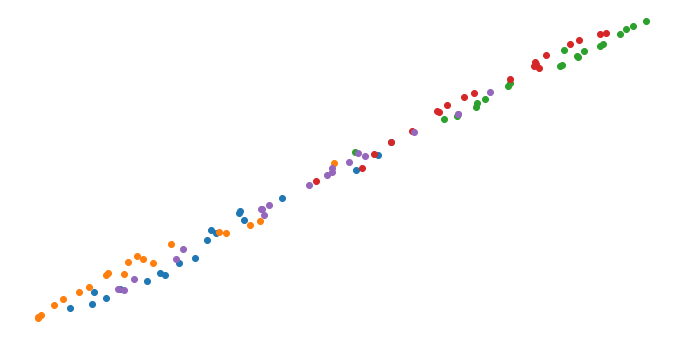

In [42]:
labels = jnp.array(labels)
plt.figure(figsize = (12,6))
for j in np.unique(labels[jnp.array(indices)]) : 
  idx = np.where(labels[jnp.array(indices)] == j)

  plt.scatter(S_wmd_emb[idx,0], S_wmd_emb[idx,1], label = j)
#plt.legend(frameon=False, loc = 'upper left', bbox_to_anchor = (1.05,1),borderaxespad=0, mode = 'extend')
plt.axis('off')

## Optimization of S-WMD

Pseudo-code \\
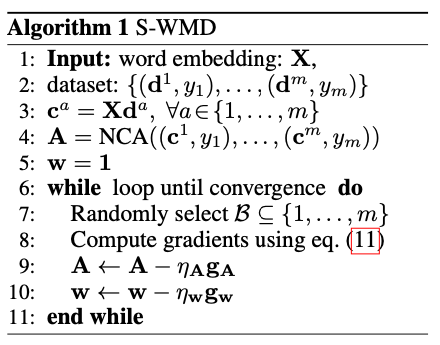

S-WMD is thus a coupling of an Optimal Transport problem (learning $D_{A,W}$) and an optimization problem (minimizing $\ell(A,w)$ in its argument). 

We can use `ott-jax` in order to compute fastly the OT distance using the Sinkhorn alogrithm, and directly compute the loss function. We use `jax` automatic differenciation in order to directly compute the gradients of the loss with respect to $A$ and $w$, and optimize using *Stochastic Gradient Descent*. 

In [13]:
@jax.jit
def WCD_matrix(A, centroids) : 
    """Compute Word Centroid Distance cost matrix"""
    dist_func = jax.jit(jax.vmap(
        lambda Centroids_1, Centroids_2, A: jax.vmap(
            lambda centroid_1, centroid_2, A: -jnp.linalg.norm(
                A @ centroid_1- 
                A @ centroid_2,
                ord = 2
            )**2,
            in_axes=[0, None, None])(Centroids_1, Centroids_2, A),
        in_axes=[None, 0, None] ))
    
    return dist_func(centroids, centroids, A)


@jax.jit
def loss_func(D_ot_i, valid_nn) : 
      dmin = jnp.min(D_ot_i)
      p_ij = jnp.exp(D_ot_i+dmin) +1e-10
      p_ij = p_ij/jnp.sum(p_ij)
      
      p_i = jnp.sum(p_ij[valid_nn]) +1e-10# to avoid division by 0

      return -jnp.log(p_i)

@jax.jit
def d_tilde(w,d) : 
  return ((w*d) / (w*d).sum()) + 1e-10 # To avoid nans in grad(w)

def batch_loss(
             X: jnp.ndarray,
             d: jnp.ndarray,
             A: jnp.ndarray,
             w: jnp.ndarray,
             labels,
             neighbors,
             batch):
    """Compute the S-WMD loss for one batch of data"""
    loss = 0
    AX = jnp.matmul(X,A.T)
    for i in batch : 
      x = labels[neighbors[i]]
      y = labels[i]
      valid_nn = jnp.where(x==y)

      D_ot_i = jitted_multi_ot(AX, d_tilde(w, d[i]), jnp.asarray([d_tilde(w, d[j]) for j in neighbors[i]]))
      loss += loss_func(D_ot_i, valid_nn)
      del D_ot_i 
    return loss

In [23]:
s_wmd_vg = jax.value_and_grad(
    (lambda X, HIST, A, w, labels, neighbors, batch : 
    batch_loss(X, HIST, A, w, labels, neighbors, batch = batch)), argnums = [2,3])

jitted_multi_ot = jax.jit(jax.vmap(
        lambda AX, HIST_i, HISTS_j: sinkhorn_divergence(
          PointCloud, AX, AX,  
          cost_fn=ott.geometry.costs.Euclidean(), epsilon = 2e-1,
          a= HIST_i, 
          b= HISTS_j,
          sinkhorn_kwargs = {'threshold' : 1e-2, 'momentum': 1.3, 'max_iterations':200},
          ).divergence,
        in_axes = [None, None, 0]))

To speed up training, S-WMD optimization defines a set of neighbors for each document in the training batch. This set of neighbors is found by taking documents that have a minimal distance from centroids: 
$$||A(c_a - c_b)||_2^2 $$
We can consider the set of $K$ most close neighbors using this distance metric. The higher the number of neighbors and the more accurate the optimization problem is at the cost of training time.

In [27]:
d = X.shape[1] #embedding dim
n = X.shape[0] #Number of words
w = jnp.ones(n) #Initialize w with ones

labels = jnp.array(labels)

lr_A = 1 #Learning rate for A
lr_w = 1 #Learning rate for w

In [28]:
top_k = 20 #Number of neighbors to consider
batch_size = 4 #Number of documents per batch. A higher batch size leads to jax memory error (why ?)
max_iter = 200 


In [29]:
total_loss = 0
indices = jnp.arange(HIST.shape[0])
rng = jax.random.PRNGKey(0)
rngs = jax.random.split(rng, max_iter)
indices = jnp.arange(HIST.shape[0])
pbar = tqdm(range(0,max_iter), desc = 'S-WMD Loss')

for it in pbar : 

  wcd_matrix = WCD_matrix(A, centroids)
  neighbors = jax.lax.top_k(wcd_matrix, top_k)[1][1:]
  del wcd_matrix

  batch = jax.random.choice(rngs[it], indices, (batch_size,))
  loss, (dA, dw) = s_wmd_vg(X, HIST, A, w, labels, neighbors, batch = batch)
  A -= lr_A * dA
  w -= lr_w * dw

  total_loss += loss.item()
  pbar.set_description(f'S-WMD Loss: {round(total_loss / (it+1), 4)}')

S-WMD Loss:   0%|          | 0/200 [00:00<?, ?it/s]

## Looking at embedding result

In [30]:
sink_div = jax.jit(jax.vmap(
    lambda geom, HIST_1, HIST_2, : jax.vmap(
        lambda geom, hist_1, hist_2 : sinkhorn_divergence(
          PointCloud, geom, geom,  epsilon = 5e-1,
          a= hist_1, 
          b= hist_2,
          sinkhorn_kwargs = {'threshold' : 1e-2},
          ).divergence,
        in_axes=[None, 0, None])(geom, HIST_1, HIST_2),
    in_axes=[ None, None,0]))

In [31]:
#We select 100 texts (20 texts per label) to test the embedding
indices = []
for j in np.unique(labels) : 
    indices.extend(np.where(labels == j)[0][:20].tolist())
indices = jnp.asarray(indices)

In [32]:
HIST_tilde = (w * HIST ) / w.reshape(1,-1).dot(HIST.T).repeat(X.shape[0],axis=0).T
lin_trans = np.matmul(X, A.T) 
pairwise_dist = sink_div(lin_trans, HIST[indices], HIST[indices])

In [33]:
pairwise_dist = np.array(pairwise_dist)
pairwise_dist[np.eye(pairwise_dist.shape[0], dtype = bool)]  = 0

In [34]:
tsne = TSNE(init = 'pca', learning_rate = 'auto', n_iter = 5000)
S_wmd_emb = tsne.fit_transform(np.array(pairwise_dist))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


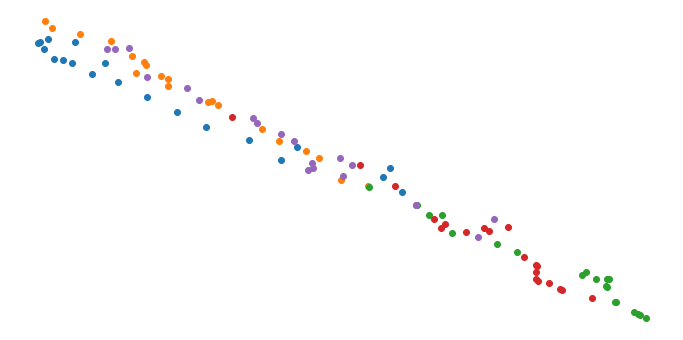

In [37]:
plt.figure(figsize = (12,6))
for j in np.unique(labels[jnp.array(indices)]) : 
  idx = np.where(labels[jnp.array(indices)] == j)

  plt.scatter(S_wmd_emb[idx,0], S_wmd_emb[idx,1], label = j)
_=plt.axis('off')

The algorithm seems to note have run for enough iterations, the solution found is quite similar to the original solution found by NCA. Increasing the number of neighbors or increasing the number of Sinkhorn's iteration should lead to better result at the cost of increasing computation power